<a href="https://colab.research.google.com/github/steliosg23/PDS-A2/blob/main/Finetuning_PubMedBERT_BENCHMARKS_PDS_A2_FHD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignement 2
### Food Hazard Detection

# Benchmarks - Advanced Model: PubMedBERT

In this task, we aim to classify food safety-related incidents based on two distinct types of input data: short texts (title) and long texts (text).

Using Advanced Model: PubMedBERT  


For each of these input types, we perform the following two subtasks:

**Subtasks (Performed Separately for  title and text):**

**Subtask 1:**

- Classify hazard-category (general hazard type).

- Classify product-category (general product type).

**Subtask 2:**

- Classify hazard (specific hazard).
- Classify product (specific product).

We use all features (year, month, day, country, and the text feature) as input.

Thus, we treat title and text as two distinct data sources, with each undergoing its own preprocessing, model training, and evaluation for all four targets.

# Mount Google Drive and Load Dataset

In this cell, we perform the following steps:
1. **Mount Google Drive**: We mount Google Drive to access files stored there, making it accessible within Google Colab.
2. **Define File Path**: We define the path to the `incidents_train.csv` file stored in Google Drive. This path will be used to load the dataset.
3. **Load Dataset**: We use `pandas` to read the CSV file into a DataFrame and then drop the unnecessary column (`Unnamed: 0`) to clean the data.

This process is essential for loading and preparing the dataset for further analysis or training.


In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the file on Google Drive
train_path = '/content/drive/MyDrive/Data/incidents_train.csv'

# Load the dataset
df = pd.read_csv(train_path)
df = df.drop(columns=['Unnamed: 0'])

Mounted at /content/drive


# Import Required Libraries

This cell imports all the necessary libraries for data processing, model training, evaluation, and visualization.
- `pandas` for data manipulation.
- `re` for regular expressions to clean text.
- `train_test_split` from `sklearn.model_selection` to split the data into training and testing sets.
- `f1_score` and `classification_report` from `sklearn.metrics` to evaluate the model's performance.
- `torch` and `transformers` for handling deep learning models and tokenization.
- `tqdm` for showing progress bars during training.
- `matplotlib` for visualizing the results.


In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  # Import tqdm for progress bars
import matplotlib.pyplot as plt  # Import matplotlib for plotting


# Configure Hyperparameters

This cell sets up the hyperparameters for model training, including:
- `max_len`: The maximum length of the input sequences.
- `batch_size`: The number of samples per batch.
- `learning_rate`: The learning rate for the optimizer.
- `epochs`: The number of training epochs.
- `model_name`: The pre-trained model (PubMedBERT in this case) to use for fine-tuning.


In [3]:
# Hyperparameters configuration
config = {
    'max_len': 256,
    'batch_size': 16,
    'learning_rate': 2e-5,
    'epochs': 5,
    'model_name': "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
}


# Set Device for Training

This cell checks whether a GPU is available and sets the device for training (either `cuda` for GPU or `cpu` for CPU).
It prints the device being used for training.


In [4]:
# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Define Custom Dataset Class

Here we define a custom PyTorch `Dataset` class to handle the text data. This class takes in the input texts, labels, tokenizer, and maximum sequence length, and implements methods to return tokenized inputs and labels in a batch.
- The `__len__` method returns the number of samples in the dataset.
- The `__getitem__` method returns tokenized input data (input ids and attention mask) and the corresponding label for a given index.


In [5]:
# Custom Dataset for Text Data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Text Preprocessing - Cleaning Function

This function cleans the text by removing any non-alphanumeric characters (e.g., punctuation) and converts the text to lowercase.
This helps standardize the text for further processing, such as tokenization and model input.


In [6]:
# Function to clean text (title or text) and remove stopwords
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = ' '.join(text.split())
    return text


# Preprocessing the Text Data

In this step, we apply the `clean_text` function to the `title` and `text` columns of the DataFrame to clean and preprocess the text data. This ensures that all the text data used for model input is in a consistent format.


In [7]:
# Load tokenizer for Microsoft PubMedBERT model
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Assuming df is your DataFrame
df['title'] = df['title'].apply(clean_text)
df['text'] = df['text'].apply(clean_text)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

# Defining Features and Targets

In this cell, we define the features (columns) used for input to the model, which include `year`, `month`, `day`, and `country`. We also define the target variables for both subtasks, such as `hazard-category`, `product-category`, `hazard`, and `product`. These will be the labels we aim to predict.


In [8]:
# Define relevant features and targets
features = ['year', 'month', 'day', 'country']
targets_subtask1 = ['hazard-category','product-category']
targets_subtask2 = ['hazard','product']


# Label Encoding for Targets

Here, we encode the categorical target labels into numeric values using `LabelEncoder` from `sklearn`. This step is necessary for training the model, as models require numeric labels for classification tasks.
For each target, a new `LabelEncoder` is created, and the target column is transformed into numeric labels.


In [9]:
# Encode target labels to numeric values
label_encoders = {}
for target in targets_subtask1 + targets_subtask2:
    le = LabelEncoder()
    df[target] = le.fit_transform(df[target])
    label_encoders[target] = le


# Data Preparation for Training and Testing

This function splits the data into training and testing sets for each target variable. It also ensures that the features and corresponding targets are aligned and reset the indices for consistency. The function returns a dictionary containing the splits for each target.


In [10]:
# Prepare data for both title and text
def prepare_data(text_column):
    X = df[features + [text_column]]
    y_subtask1 = df[targets_subtask1]
    y_subtask2 = df[targets_subtask2]

    data_splits = {}
    for target in targets_subtask1 + targets_subtask2:
        X_train, X_test, y_train, y_test = train_test_split(
            X, df[target], test_size=0.2, random_state=42
        )

        # Reset indices to ensure matching
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        data_splits[target] = (X_train, X_test, y_train, y_test)

    return data_splits


# Prepare Data for Title and Text Subtasks

This step prepares separate data splits for the `title` and `text` columns. It uses the `prepare_data` function to generate data splits for both input types, which will be used to train and evaluate the models.


In [11]:
# Prepare data for title and text
title_splits = prepare_data('title')
text_splits = prepare_data('text')


# Model Training and Evaluation

- This function trains and evaluates the model for each target variable. It creates the DataLoader objects for the training and testing data, sets up the model, and runs the training loop. It also evaluates the model's performance by calculating the F1 score and printing the classification report.

- The training loop updates the model's weights using backpropagation, and the evaluation phase computes the model's predictions and compares them with the true labels.



In [12]:
# Function to train and evaluate neural network models
def train_and_evaluate_nn(data_splits, targets, model_type='title'):
    f1_scores = []  # List to store F1 scores for each task

    for target in targets:
        print(f"\nStarting training for task: {target}")  # Print task message

        X_train, X_test, y_train, y_test = data_splits[target]

        # Prepare text data using the tokenizer
        if model_type == 'title':
            texts_train = X_train['title'].values
            texts_test = X_test['title'].values
        else:
            texts_train = X_train['text'].values
            texts_test = X_test['text'].values

        # Create DataLoader for training and testing
        train_dataset = TextDataset(texts_train, y_train, tokenizer, config['max_len'])
        test_dataset = TextDataset(texts_test, y_test, tokenizer, config['max_len'])

        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

        # Model setup
        num_labels = len(label_encoders[target].classes_)  # Corrected here
        model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=num_labels).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.CrossEntropyLoss()

        # Training process
        model.train()
        for epoch in range(config['epochs']):
            print(f"Epoch {epoch+1}/{config['epochs']} - Training: {target}")
            progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", total=len(train_loader), leave=True)
            for batch in progress_bar:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].squeeze(1).to(device)
                attention_mask = batch['attention_mask'].squeeze(1).to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                loss.backward()
                optimizer.step()
                progress_bar.set_postfix(loss=loss.item())

        # Evaluation process
        print(f"Evaluating model for task: {target}")
        model.eval()
        y_preds = []
        y_true = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating", total=len(test_loader), leave=True):
                input_ids = batch['input_ids'].squeeze(1).to(device)
                attention_mask = batch['attention_mask'].squeeze(1).to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs.logits, dim=1)
                y_preds.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        # Decode labels back to original categories using the label encoder
        decoded_preds = label_encoders[target].inverse_transform(y_preds)
        decoded_true = label_encoders[target].inverse_transform(y_true)

        # Calculate F1 score for the task
        f1 = f1_score(decoded_true, decoded_preds, average='weighted')
        f1_scores.append(f1)
        print(f"F1-Score for {target}: {f1}")

        # Print classification report
        print(f"Classification Report for {target}:\n")
        print(classification_report(decoded_true, decoded_preds,zero_division=0))

    return f1_scores  # Return the list of F1 scores for plotting


# Train and Evaluate for Title and Text Subtasks

This step trains and evaluates the model separately for the `title` and `text` features. It calls the `train_and_evaluate_nn` function for both types of input (title and text) and stores the F1 scores for comparison.


In [13]:
# Train and evaluate for both title and text
print("\nTraining and Evaluating for Title Tasks:")
title_f1_scores = train_and_evaluate_nn(title_splits, targets_subtask1 + targets_subtask2, model_type='title')

print("\nTraining and Evaluating for Text Tasks:")
text_f1_scores = train_and_evaluate_nn(text_splits, targets_subtask1 + targets_subtask2, model_type='text')



Training and Evaluating for Title Tasks:

Starting training for task: hazard-category


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Training: hazard-category


Training Epoch 1: 100%|██████████| 255/255 [00:42<00:00,  6.04it/s, loss=0.0476]


Epoch 2/5 - Training: hazard-category


Training Epoch 2: 100%|██████████| 255/255 [00:40<00:00,  6.28it/s, loss=0.195]


Epoch 3/5 - Training: hazard-category


Training Epoch 3: 100%|██████████| 255/255 [00:40<00:00,  6.29it/s, loss=0.0166]


Epoch 4/5 - Training: hazard-category


Training Epoch 4: 100%|██████████| 255/255 [00:40<00:00,  6.31it/s, loss=0.00826]


Epoch 5/5 - Training: hazard-category


Training Epoch 5: 100%|██████████| 255/255 [00:40<00:00,  6.31it/s, loss=0.00967]


Evaluating model for task: hazard-category


Evaluating: 100%|██████████| 64/64 [00:03<00:00, 18.73it/s]


F1-Score for hazard-category: 0.8288061615398531
Classification Report for hazard-category:

                                precision    recall  f1-score   support

                     allergens       0.84      0.93      0.88       377
                    biological       0.88      0.91      0.90       339
                      chemical       0.81      0.65      0.72        68
food additives and flavourings       0.00      0.00      0.00         5
                foreign bodies       0.81      0.74      0.77       111
                         fraud       0.78      0.63      0.70        68
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.44      0.40      0.42        10
                  other hazard       0.58      0.56      0.57        27
              packaging defect       0.43      0.27      0.33        11

                      accuracy                           0.84      1017
                     macro avg       0.56

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Training: product-category


Training Epoch 1: 100%|██████████| 255/255 [00:40<00:00,  6.31it/s, loss=1.79]


Epoch 2/5 - Training: product-category


Training Epoch 2: 100%|██████████| 255/255 [00:40<00:00,  6.31it/s, loss=1.33]


Epoch 3/5 - Training: product-category


Training Epoch 3: 100%|██████████| 255/255 [00:40<00:00,  6.30it/s, loss=0.548]


Epoch 4/5 - Training: product-category


Training Epoch 4: 100%|██████████| 255/255 [00:40<00:00,  6.30it/s, loss=4.55]


Epoch 5/5 - Training: product-category


Training Epoch 5: 100%|██████████| 255/255 [00:40<00:00,  6.31it/s, loss=0.539]


Evaluating model for task: product-category


Evaluating: 100%|██████████| 64/64 [00:03<00:00, 18.57it/s]


F1-Score for product-category: 0.7494399573273808
Classification Report for product-category:

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.83      0.71      0.77         7
                      cereals and bakery products       0.70      0.80      0.75       123
     cocoa and cocoa preparations, coffee and tea       0.69      0.78      0.73        49
                                    confectionery       0.42      0.55      0.47        40
dietetic foods, food supplements, fortified foods       0.72      0.75      0.73        24
                                    fats and oils       1.00      0.50      0.67         4
                                   feed materials       0.00      0.00      0.00         3
                           food contact materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.83      0.74      0.78     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Training: hazard


Training Epoch 1: 100%|██████████| 255/255 [00:40<00:00,  6.30it/s, loss=4.67]


Epoch 2/5 - Training: hazard


Training Epoch 2: 100%|██████████| 255/255 [00:40<00:00,  6.30it/s, loss=1.22]


Epoch 3/5 - Training: hazard


Training Epoch 3: 100%|██████████| 255/255 [00:40<00:00,  6.29it/s, loss=0.401]


Epoch 4/5 - Training: hazard


Training Epoch 4: 100%|██████████| 255/255 [00:40<00:00,  6.30it/s, loss=0.0824]


Epoch 5/5 - Training: hazard


Training Epoch 5: 100%|██████████| 255/255 [00:40<00:00,  6.29it/s, loss=0.0689]


Evaluating model for task: hazard


Evaluating: 100%|██████████| 64/64 [00:03<00:00, 18.68it/s]


F1-Score for hazard: 0.5899028144423755
Classification Report for hazard:

                                                   precision    recall  f1-score   support

                                        Aflatoxin       1.00      0.50      0.67         4
                                  alcohol content       0.00      0.00      0.00         1
                                        alkaloids       0.00      0.00      0.00         2
                                        allergens       0.00      0.00      0.00         4
                                           almond       0.71      0.71      0.71        14
             altered organoleptic characteristics       0.00      0.00      0.00         2
                                        amygdalin       0.00      0.00      0.00         2
                           antibiotics, vet drugs       0.00      0.00      0.00         1
                                    bacillus spp.       0.00      0.00      0.00         1
              

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Training: product


Training Epoch 1: 100%|██████████| 255/255 [00:40<00:00,  6.30it/s, loss=7.51]


Epoch 2/5 - Training: product


Training Epoch 2: 100%|██████████| 255/255 [00:40<00:00,  6.31it/s, loss=5.49]


Epoch 3/5 - Training: product


Training Epoch 3: 100%|██████████| 255/255 [00:40<00:00,  6.31it/s, loss=4.04]


Epoch 4/5 - Training: product


Training Epoch 4: 100%|██████████| 255/255 [00:40<00:00,  6.29it/s, loss=2.03]


Epoch 5/5 - Training: product


Training Epoch 5: 100%|██████████| 255/255 [00:40<00:00,  6.30it/s, loss=6.56]


Evaluating model for task: product


Evaluating: 100%|██████████| 64/64 [00:03<00:00, 18.65it/s]


F1-Score for product: 0.21723957019281764
Classification Report for product:

                                                   precision    recall  f1-score   support

                           Catfishes (freshwater)       0.75      0.60      0.67         5
                            Fishes not identified       0.31      0.83      0.45         6
                         Not classified pork meat       0.00      0.00      0.00         3
                       Pangas catfishes (generic)       0.00      0.00      0.00         1
              Precooked cooked pork meat products       0.00      0.00      0.00         1
                                    Veggie Burger       0.00      0.00      0.00         2
                               after dinner mints       0.00      0.00      0.00         1
                                  alfalfa sprouts       0.00      0.00      0.00         0
                                            algae       0.00      0.00      0.00         3
           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Training: hazard-category


Training Epoch 1: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.129]


Epoch 2/5 - Training: hazard-category


Training Epoch 2: 100%|██████████| 255/255 [00:46<00:00,  5.53it/s, loss=0.0175]


Epoch 3/5 - Training: hazard-category


Training Epoch 3: 100%|██████████| 255/255 [00:46<00:00,  5.53it/s, loss=0.0559]


Epoch 4/5 - Training: hazard-category


Training Epoch 4: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.0165]


Epoch 5/5 - Training: hazard-category


Training Epoch 5: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.0209]


Evaluating model for task: hazard-category


Evaluating: 100%|██████████| 64/64 [00:04<00:00, 13.06it/s]


F1-Score for hazard-category: 0.945867013097105
Classification Report for hazard-category:

                                precision    recall  f1-score   support

                     allergens       0.95      0.99      0.97       377
                    biological       0.99      0.99      0.99       339
                      chemical       0.88      0.97      0.92        68
food additives and flavourings       0.00      0.00      0.00         5
                foreign bodies       0.98      0.98      0.98       111
                         fraud       0.87      0.69      0.77        68
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.89      0.80      0.84        10
                  other hazard       0.72      0.85      0.78        27
              packaging defect       0.88      0.64      0.74        11

                      accuracy                           0.95      1017
                     macro avg       0.72 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Training: product-category


Training Epoch 1: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.0924]


Epoch 2/5 - Training: product-category


Training Epoch 2: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.449]


Epoch 3/5 - Training: product-category


Training Epoch 3: 100%|██████████| 255/255 [00:46<00:00,  5.51it/s, loss=0.448]


Epoch 4/5 - Training: product-category


Training Epoch 4: 100%|██████████| 255/255 [00:46<00:00,  5.53it/s, loss=2.07]


Epoch 5/5 - Training: product-category


Training Epoch 5: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.0674]


Evaluating model for task: product-category


Evaluating: 100%|██████████| 64/64 [00:04<00:00, 12.95it/s]


F1-Score for product-category: 0.7582886155879994
Classification Report for product-category:

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.75      0.86      0.80         7
                      cereals and bakery products       0.70      0.77      0.74       123
     cocoa and cocoa preparations, coffee and tea       0.65      0.86      0.74        49
                                    confectionery       0.58      0.47      0.52        40
dietetic foods, food supplements, fortified foods       0.89      0.71      0.79        24
                                    fats and oils       1.00      0.50      0.67         4
                                   feed materials       0.00      0.00      0.00         3
                           food contact materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.74      0.84      0.79     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Training: hazard


Training Epoch 1: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.713]


Epoch 2/5 - Training: hazard


Training Epoch 2: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.06]


Epoch 3/5 - Training: hazard


Training Epoch 3: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.017]


Epoch 4/5 - Training: hazard


Training Epoch 4: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.0172]


Epoch 5/5 - Training: hazard


Training Epoch 5: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=0.0144]


Evaluating model for task: hazard


Evaluating: 100%|██████████| 64/64 [00:04<00:00, 13.03it/s]


F1-Score for hazard: 0.81660664738006
Classification Report for hazard:

                                                   precision    recall  f1-score   support

                                        Aflatoxin       1.00      1.00      1.00         4
                                  alcohol content       0.00      0.00      0.00         1
                                        alkaloids       0.00      0.00      0.00         2
                                        allergens       0.00      0.00      0.00         4
                                           almond       0.87      0.93      0.90        14
             altered organoleptic characteristics       0.00      0.00      0.00         2
                                        amygdalin       0.00      0.00      0.00         2
                           antibiotics, vet drugs       0.00      0.00      0.00         1
                                    bacillus spp.       1.00      1.00      1.00         1
                

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Training: product


Training Epoch 1: 100%|██████████| 255/255 [00:46<00:00,  5.51it/s, loss=6.03]


Epoch 2/5 - Training: product


Training Epoch 2: 100%|██████████| 255/255 [00:46<00:00,  5.51it/s, loss=3.35]


Epoch 3/5 - Training: product


Training Epoch 3: 100%|██████████| 255/255 [00:46<00:00,  5.50it/s, loss=6.91]


Epoch 4/5 - Training: product


Training Epoch 4: 100%|██████████| 255/255 [00:46<00:00,  5.51it/s, loss=4.87]


Epoch 5/5 - Training: product


Training Epoch 5: 100%|██████████| 255/255 [00:46<00:00,  5.51it/s, loss=4.55]


Evaluating model for task: product


Evaluating: 100%|██████████| 64/64 [00:04<00:00, 13.03it/s]

F1-Score for product: 0.23310343365556174
Classification Report for product:

                                                   precision    recall  f1-score   support

                           Catfishes (freshwater)       1.00      0.20      0.33         5
                            Fishes not identified       0.23      1.00      0.38         6
                         Not classified pork meat       0.00      0.00      0.00         3
                       Pangas catfishes (generic)       0.00      0.00      0.00         1
              Precooked cooked pork meat products       0.00      0.00      0.00         1
                                    Veggie Burger       0.00      0.00      0.00         2
                               after dinner mints       0.00      0.00      0.00         1
                                  alfalfa sprouts       0.00      0.00      0.00         0
                                            algae       0.00      0.00      0.00         3
           

# Create DataFrames for F1 Scores

This cell creates two DataFrames, one for the title-focused F1 scores and another for the text-focused F1 scores. These DataFrames will be used for plotting the results.


In [16]:
# Create DataFrames for F1 scores for title and text
f1_scores_title_df = pd.DataFrame({
    'Task': targets_subtask1 + targets_subtask2,
    'F1-Score': title_f1_scores
})

f1_scores_text_df = pd.DataFrame({
    'Task': targets_subtask1 + targets_subtask2,
    'F1-Score': text_f1_scores
})
# Print the collected F1-scores for title
print("\nCollected F1-Scores for Title-Focused Classification:")
print(f1_scores_title_df)

# Print the collected F1-scores for text
print("\nCollected F1-Scores for Text-Focused Classification::")
print(f1_scores_text_df)


Collected F1-Scores for Title-Focused Classification:
               Task  F1-Score
0   hazard-category  0.828806
1  product-category  0.749440
2            hazard  0.589903
3           product  0.217240

Collected F1-Scores for Text-Focused Classification::
               Task  F1-Score
0   hazard-category  0.945867
1  product-category  0.758289
2            hazard  0.816607
3           product  0.233103


# Plot F1 Scores for Title and Text Subtasks

This cell visualizes the F1 scores for the title and text-based tasks by plotting them in a bar chart. It displays both sets of F1 scores in a combined chart for comparison.


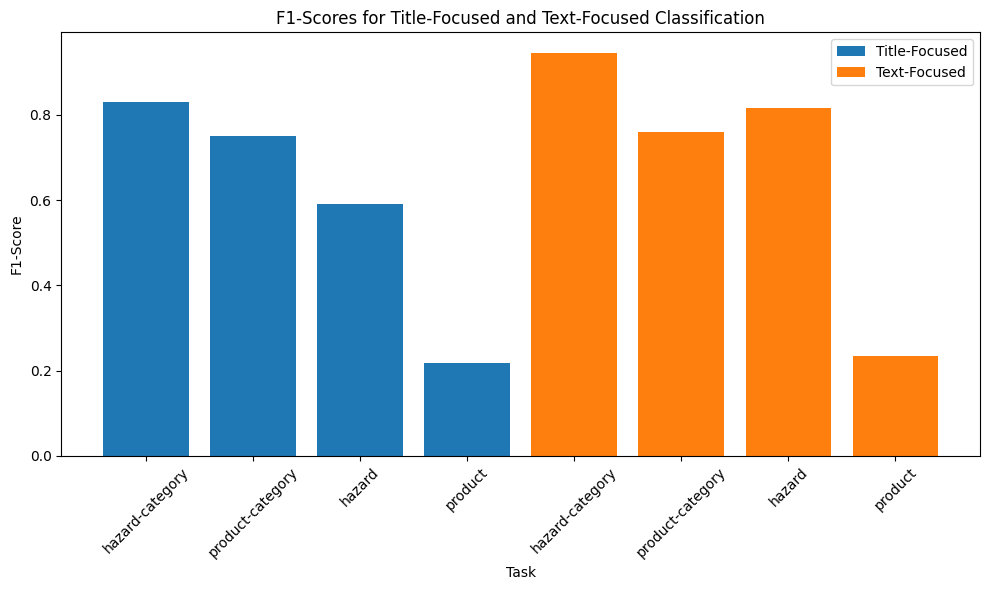

In [15]:
# Plotting the data
plt.figure(figsize=(10, 6))

index_title = range(len(f1_scores_title_df))  # Position for Title-Focused
index_text = [i + len(f1_scores_title_df) for i in range(len(f1_scores_text_df))]  # Position for Text-Focused

# Plotting all Title-Focused F1-scores
plt.bar(index_title, f1_scores_title_df['F1-Score'], label='Title-Focused')

# Plotting all Text-Focused F1-scores (shifted on the x-axis after the Title-Focused bars)
plt.bar(index_text, f1_scores_text_df['F1-Score'], label='Text-Focused')

# Adding labels and title
plt.xlabel('Task')
plt.ylabel('F1-Score')
plt.title('F1-Scores for Title-Focused and Text-Focused Classification')

# Adjusting x-ticks to show all tasks
plt.xticks(range(len(f1_scores_title_df) + len(f1_scores_text_df)),
           list(f1_scores_title_df['Task']) + list(f1_scores_text_df['Task']),
           rotation=45)

# Adding legend
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()
